In [86]:
import seaborn as sns
sns.set_style('white')

In [87]:
# data from Knowles et al 2015
dat = pd.DataFrame()
dat['year'] = [2008,2009,2010,2011,2012]
dat['Pknowles'] = [955,841,855,1198,800]
dat['Q'] = [175,194,238,327,131]
dat['alpET'] = [399,415,385,414,360]
dat['forET'] = [621,593,576,624,621]
dat['catET'] = [633,596,579,672,592]
#dat['PET'] = [] # get from RHESSys
dat.index = dat.year

In [88]:
df = pd.read_pickle('./data/como_precip_comparison.pcl')

In [89]:
dat['Pdist'] = df.distribution

In [90]:
alpArea = 0.31
forArea = 1-alpArea

In [91]:
def compute_ET(df):
    return alpArea*df.alpET + forArea*df.forET

In [92]:
dat['ET'] = dat.apply(compute_ET,axis=1)

In [93]:
def make_date(df):
    return str(pd.datetime(int(df.year),int(df.month),int(df.day)).date())

In [94]:
# read in the PET data from RHESSys
df = pd.read_table('/RHESSys/Como/out/cal.grid.PET_basin.daily',sep=' ')
df['datetime'] = df.apply(make_date,axis=1)
df.index = pd.DatetimeIndex(df.datetime)
del df['datetime']
df['wateryear'] = df.index.map(rut.wateryear)

In [95]:
dat['PET']=df.loc[(df.wateryear>=2008) & (df.wateryear <=2012)].groupby(by='wateryear')['pet'].sum().as_matrix()

In [96]:
dat['RknowlesP_catET'] = dat.Pknowles-dat.catET
dat['RknowlesP_MeasET'] = dat.Pknowles-dat.ET
dat['RdistP_catET'] = dat.Pdist-dat.catET
dat['RdistP_MeasET'] = dat.Pdist-dat.ET

In [97]:
# estimate leakage
dat['leakage_KPCET'] = dat.RknowlesP_catET - dat.Q
dat['leakage_KPMET'] = dat.RknowlesP_MeasET - dat.Q
dat['leakage_DPCET'] = dat.RdistP_catET - dat.Q
dat['leakage_DPMET'] = dat.RdistP_MeasET - dat.Q

## Notes:

$ \Delta S = leakage = Q - (P+ET)$

This is very similar to the change in storage equation from Knowles et al 2015

# update below to include a knowles estimate with blowing snow ET

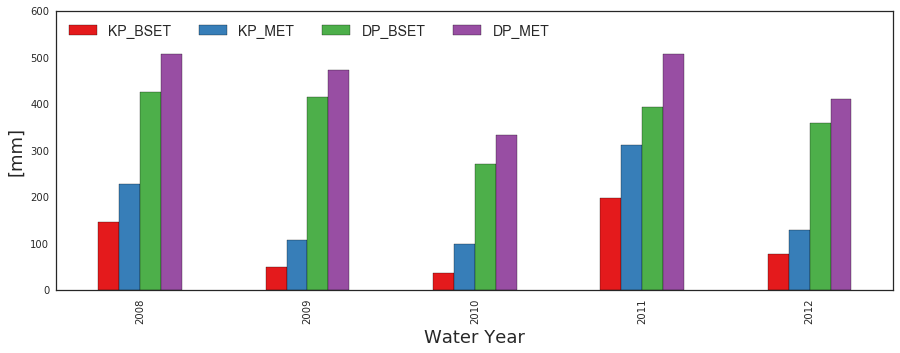

In [98]:
leakages = ['leakage_KPCET','leakage_KPMET','leakage_DPCET','leakage_DPMET']
names = ['KP_BSET','KP_MET','DP_BSET','DP_MET']
dat[leakages].plot.bar(figsize=(15,5),color = ['#e41a1c','#377eb8','#4daf4a','#984ea3'])
plt.legend(names,bbox_to_anchor=(0, 1), loc='upper left', ncol=4, fontsize=14)
plt.xlabel('Water Year', fontsize = 18)
plt.ylabel('[mm]', fontsize = 18)

## Bring this together with long-term precip climatiology

In [125]:
Pdat = pd.read_pickle('./data/como_gridded_summary.pcl') # load the data
Pdat = Pdat.groupby('wateryear').sum() # summarize by water year
Pdat.P *= 1000.
Pdat['Panom'] = Pdat.P - Pdat.P.mean() # subtract the mean P from P
Pdat['PanomSum'] = Pdat.Panom.cumsum()

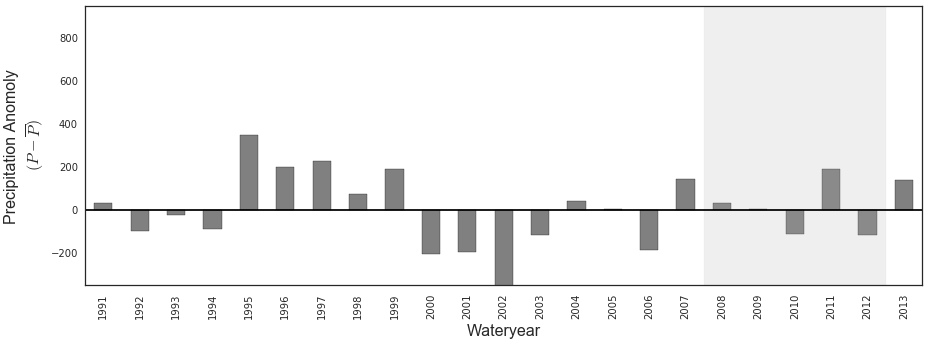

In [147]:
Pdat.Panom.plot.bar(figsize=(15,5),facecolor='0.5')
plt.axhline(0,color='k')
plt.ylim(-350,950)
plt.xlabel('Wateryear', fontsize = 16)
plt.ylabel('Precipitation Anomoly\n $(P - \overline{P})$', fontsize=16)
plt.axvspan(16.5,21.5,color='0.7',alpha=0.2)
#plt.savefig('./figures/como_precip_climatology.png',dpi=300,bbox_inches='tight')

## Bring both plots together

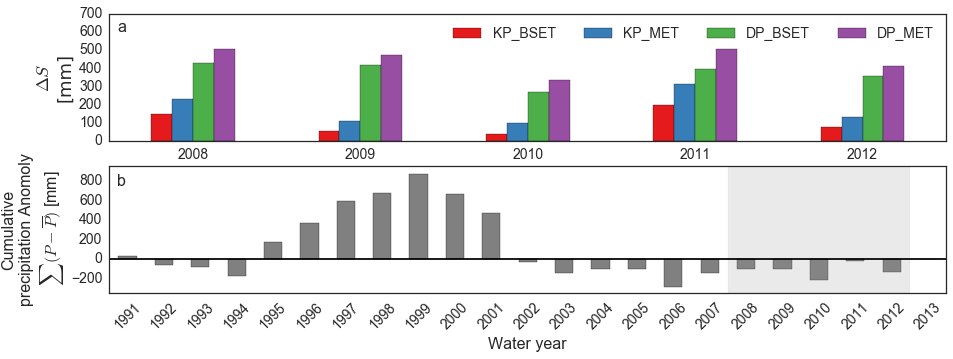

In [148]:
fig = plt.figure(figsize=(5.5,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
leakages = ['leakage_KPCET','leakage_KPMET','leakage_DPCET','leakage_DPMET']
names = ['KP_BSET','KP_MET','DP_BSET','DP_MET']
dat[leakages].plot.bar(figsize=(15,5),color = ['#e41a1c','#377eb8','#4daf4a','#984ea3'],ax=ax1)
ax1.legend(names, loc='upper right', ncol=4, fontsize=14)
ax1.set_xticklabels([2008,2009,2010,2011,2012])
ax1.set_ylabel('$\Delta S$\n[mm]', fontsize = 18)
[tick.set_rotation(0) for tick in ax1.get_xticklabels()] # rotate labels
[tick.set_fontsize(14) for tick in ax1.get_xticklabels()] # set xtick fontsize
[tick.set_fontsize(14) for tick in ax1.get_yticklabels()] # set ytick fontsize
ax1.set_xlabel(' ')
ax1.set_ylim(0,700)
ax1.text(-0.45,600,'a', fontsize=16)

Pdat.PanomSum.plot.bar(figsize=(15,5),facecolor='0.5',ax=ax2)
ax2.axhline(0,color='k')
ax2.set_ylim(-350,950)
ax2.set_xlabel('Water year', fontsize = 16)
ax2.set_ylabel('Cumulative\nprecipitation Anomoly\n $\sum(P - \overline{P})$ [mm]', fontsize=16)
ax2.axvspan(16.5,21.5,color='0.6',alpha=0.2)
ax2.text(-0.3,750,'b', fontsize=16)
[tick.set_rotation(45) for tick in ax2.get_xticklabels()] # set xtick rotation
[tick.set_fontsize(14) for tick in ax2.get_xticklabels()] # set xtick fontsize
[tick.set_fontsize(14) for tick in ax2.get_yticklabels()] # set ytick fontsize
plt.savefig('./figures/water_balance_leakage.png',dpi=300,bbox_inches='tight')